# Estudio de señales
En este Notebook se estudian las señales a trabajar en este proyecto.

Se estudiarán señales sintéticas, barridos en frecuencia o señales cuadradas, así como también señales "orgánicas" como extractos de música o grabaciones. En particular, se estudiará cuales son las señales "orgánicas" ideales con las que se pueden trabajar y se tomarán decisiones según  ciertos criterios de decisión, las señales elegidas son las que serán usadas en el trabajo principal.

## Librerías necesarias

In [80]:
import numpy as np
import importlib, aux
importlib.reload(aux)    # MUY importante
import wave
from scipy import signal
from scipy.fft import fft, ifft
from IPython.display import Image
from scipy.io.wavfile import write, read
import struct
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import sounddevice as sd
import soundfile as sf
from pydub import AudioSegment, effects  

# Sistema

El trabajo se basa en modelar la respuesta al impulso $h(n)$ de un sistema parlante-habitación-micrófono con identificación de sistemas, asumiendo
régimen estacionario. Nuestro sistema cuenta con 3 elementos: parlante, habitación y micrófono que podemos estudiar para intentar obtener la mejor estimación posible del mismo.

Se realizaron mediciones en dos escenarios distintos donde el único elemento común fue el micrófono.

## Micrófono - Tonor TC30

![Texto alternativo](tonor_Small.jpeg)

| Característica              | **Tonor TC30 (USB Cardioide)**         | **Micrófono integrado PC / Celular** |
|------------------------------|----------------------------------------|--------------------------------------|
| Tipo                         | Condensador USB, patrón **cardioide**  | Electret / MEMS integrado, omnidireccional |
| Sensibilidad                 | –32 dB ±3 dB                          | Variable, típicamente –45 a –50 dB   |
| Relación señal-ruido (SNR)   | > 68 dB                               | ~55–60 dB                            |
| Respuesta en frecuencia      | 50 Hz – 20 kHz                        | Limitada (aprox. 100 Hz – 12/15 kHz) |
| Dirección de captación       | Frontal (reduce ruido lateral)        | Omnidireccional (capta todo el entorno) |
| Calidad de medición          | Más uniforme, menos ruido ambiente, mejor resolución de barridos | Mayor ruido, menor claridad, más sensible a reflexiones |

El Tonor TC30 ofrece una mayor sensibilidad y una mejor relación señal-ruido que los micrófonos integrados de computadora o celular. Al ser cardioide, concentra la captación en la fuente deseada y reduce la influencia del ambiente, lo que resulta clave para registrar barridos de frecuencia y obtener una respuesta al impulso más clara y confiable. Un micrófono integrado, en cambio, introduce más ruido de fondo y limita la fidelidad en frecuencias graves y agudas. Por lo tanto, para mediciones de sala donde se busca precisión y repetibilidad, el TC30 es una opción claramente superior.

## Habitación + Parlante

Se propusieron dos espacios distintos para realizar la experencia. El primero un living que tenía accesible una barra de sonido con un subwoofer y luego un cuarto donde se utilizaron los parlantes de una notebook. Se analizaron los espectogramas del barrido exponencial por considerar que esta señal es la que tiene la mayor riqueza espectral para el oído humano, que es más sensible a bajas frecuencias.

![Texto alternativo](espec.png)

### Living

El living es un espacio amplio, de geometría irregular y con una carga normal de muebles. Se encuentra en un décimo piso con frente a la calle, lo que aporta un nivel constante de ruido de tráfico de la ciudad de Buenos Aires. La reproducción del sweep se realizó con una barra de sonido Samsung estándar acompañada de un subwoofer. Esto generó un espectrograma con mayor energía en bajas frecuencias, pero también con un fondo más ruidoso y reverberante. La traza del sweep aparece acompañada de ruido y reflexiones difusas, propias tanto del espacio amplio como de la respuesta del sistema de parlantes.

![Texto alternativo](espec_living.png)

### Habitación interna

La habitación es más pequeña y regular, con carga normal de muebles, sin contacto directo con el exterior. Aunque se percibe tráfico de forma atenuada, el nivel de ruido es claramente menor que en el living. En este caso, la reproducción se hizo con los parlantes integrados de una MacBook Pro de 17 pulgadas, cuya respuesta en bajas frecuencias es más limitada que la de la barra de sonido. El resultado es un espectrograma más limpio y con una traza del sweep definida, aunque con menor extensión en graves y resonancias más localizadas en medias.

![Texto alternativo](espec_cuarto.png)

⸻

Comparación y resumen
- Ruido de fondo: Mayor en el living por su orientación a la calle; menor en la habitación interna.
- Fuente de sonido:

        Living: Barra de sonido + subwoofer → más graves, mayor presencia de ruido y reverberación.
        Habitación interna: Parlantes de notebook → menos graves, sweep más claro y definido.
- Reflexiones: Difusas en el living (espacio amplio e irregular); más notorias y localizadas en la habitación (espacio pequeño y cerrado).

Conclusión:

**Se eligieron las grabaciones realizadas en la habitación interna, ya que, aunque presentan una respuesta más limitada en bajas frecuencias debido a los parlantes utilizados, ofrecen menor ruido urbano y menos reverberación. El objetivo del trabajo no es analizar un espacio grande e irregular, sino obtener la medición más limpia y representativa posible del sistema.**


# Señales de trabajo

Para obtener la mejor estimación posible es necesario trabajar con una señal que tenga el mayor rango de frecuencias posibles. Esto se debe a no se podrá estimar el comportamiento del sistema en aquellos rango donde no haya contenido espectral, ya que no se podrá obtener ninguna correlación entre la señal de entrada y la señal deseada.


## Señales "orgánicas"

Llamamos señales "orgánicas" a las que no van a ser sintetizadas, en nuestro caso la señal de música y la señal de voz. Investigamos las señales con mayor rango dinámico entre géneros musicales. Según el paper de la fuente, los mejores genéros posibles son la música de camara y el piano. 

Consiguientemente se seleccionó un fragmento de la novena sinfonía de Beethoven descargada desde este [link](https://archive.org/details/onclassical-quality-wav-audio-files-of-classical-music/onclassical_demo_roccato_anonymous-roccato_riflessi_small-version.wav) en formato wav para preservar la mayor calidad posible. Para la muestra de piano se uso un fragmento del Waltz Op.54-1 en formato wav , descargado de este [link](https://ia802200.us.archive.org/4/items/abc-tube-hi-fi-piano-wav/04.%20Waltz%20Op.54-1.wav).

Fuente: [Dynamic Range Across Music Genres (ResearchGate)](https://www.researchgate.net/publication/293822323_Dynamic_Range_Across_Music_Genres_and_the_Perception_of_Dynamic_Compression_in_Hearing-Impaired_Listeners)

![Texto alternativo](DR_Medium.jpeg)

La figura muestra los niveles de presión sonora (SPL) en función de la frecuencia para distintos tipos de música y para la voz. La señal de discurso (azul) se caracteriza por mantener un nivel relativamente estable en la banda de 1 a 5 kHz, donde se concentra la inteligibilidad del habla. En contraste, la Novena Sinfonía de Beethoven (orquesta) debería presentar un espectro mucho más complejo, con alta energía en bajas frecuencias y variaciones amplias en todo el rango. El vals debería ocupar una posición intermedia: tiene estructura rítmica clara, energía en el rango medio y un contenido espectral menos extremo que la gran orquesta.

Estas diferencias hacen que las tres señales resulten complementarias para el análisis. El discurso permite estudiar cómo se conserva la inteligibilidad en las mediciones; la sinfonía aporta un caso de máxima complejidad espectral y dinámica; y el vals representa un ejemplo de señal musical con características intermedias, útil para observar un balance entre graves, medios y agudos.

En la búsqueda de señales ideales para análisis acústico, lo más conveniente es combinar una señal específica y predecible (como el discurso, donde se sabe qué frecuencias son críticas) con una señal rica y compleja (como la sinfonía) y una de carácter intermedio (el vals). De esta forma se cubre un abanico amplio de condiciones, desde la inteligibilidad básica hasta la exigencia de reproducir pasajes orquestales con gran rango dinámico.

| Señal                          | Características principales                                  | Uso en el análisis                                      |
|--------------------------------|--------------------------------------------------------------|--------------------------------------------------------|
| Discurso (voz)                 | Énfasis en 1–5 kHz, bajo contenido en graves                 | Evaluar inteligibilidad y claridad                     |
| Novena Sinfonía (orquesta)     | Alta energía en graves, espectro amplio y complejo           | Analizar respuesta del sistema en condiciones exigentes |
| Vals                           | Perfil intermedio, energía en rango medio, estructura rítmica | Caso de estudio equilibrado entre voz y orquesta       |




# 1.1 Señal de voz - $x_1(n)$
Considerando la gráfica presentada anteriormente se usará como señal de voz la de un ([discurso](https://www.youtube.com/watch?v=NiKtZgImdlY)). Eventualmente se investigará la conveniencia de usar un tipo de voz en particular según los valores obtenidos  para lograr optimizar una banda en particular.

/var/folders/_t/g_d_mdfj26jg8hrgxw05jn6w0000gn/T/ipykernel_48789/1489278366.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x_speech = read('../PASA-TP2/tracks/x_speech.wav')


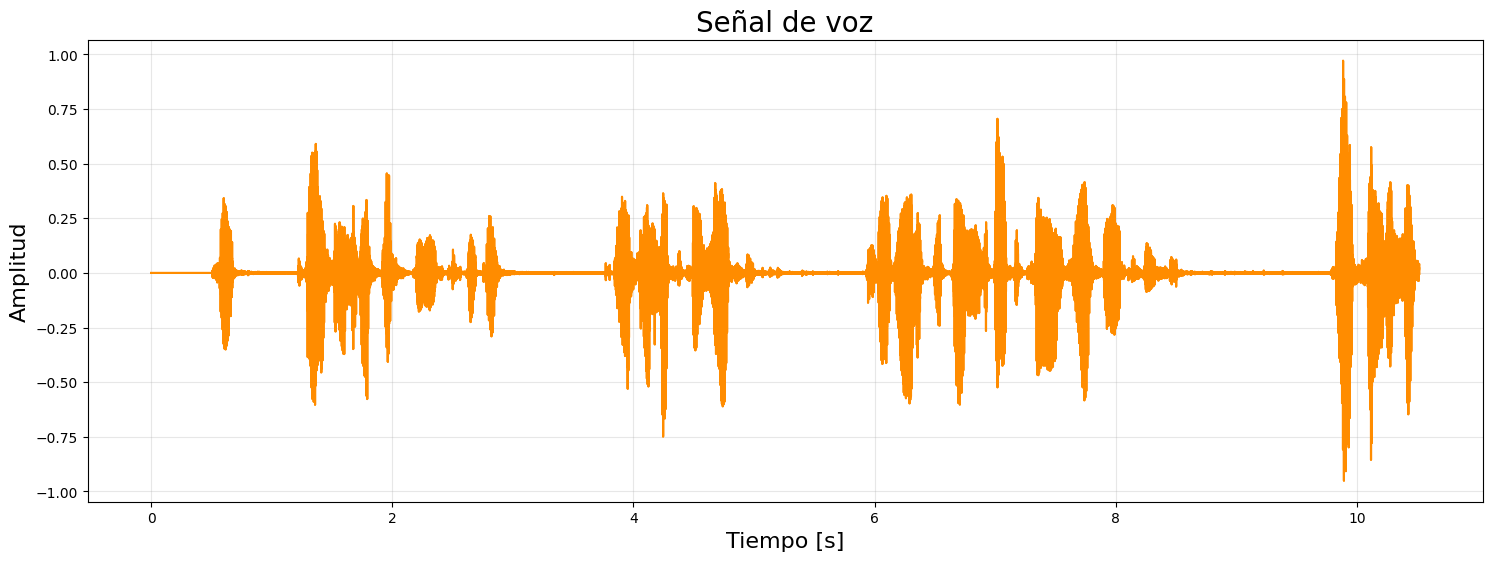

In [34]:
fs, x_speech = read('../PASA-TP2/tracks/x_speech.wav')
aux.plot_signal(x_speech, fs, title="Señal de voz")

### 1.2 Señal de música $x_2(n)$
Como se observó que por debajo de una voz dando un discurso, el género musical con mayor riqueza de espectro es la música de cámara y la orquesta. Sin conocer todavía la forma aproximada que puede tener la respuesta al impulso de la habitación a medir se decide utilizar una muestra de música de orquesta y de piano como se planteó anteriormente. 

/var/folders/_t/g_d_mdfj26jg8hrgxw05jn6w0000gn/T/ipykernel_48789/4203547915.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x_b9s = read('../PASA-TP2/tracks/x_B9S.wav')


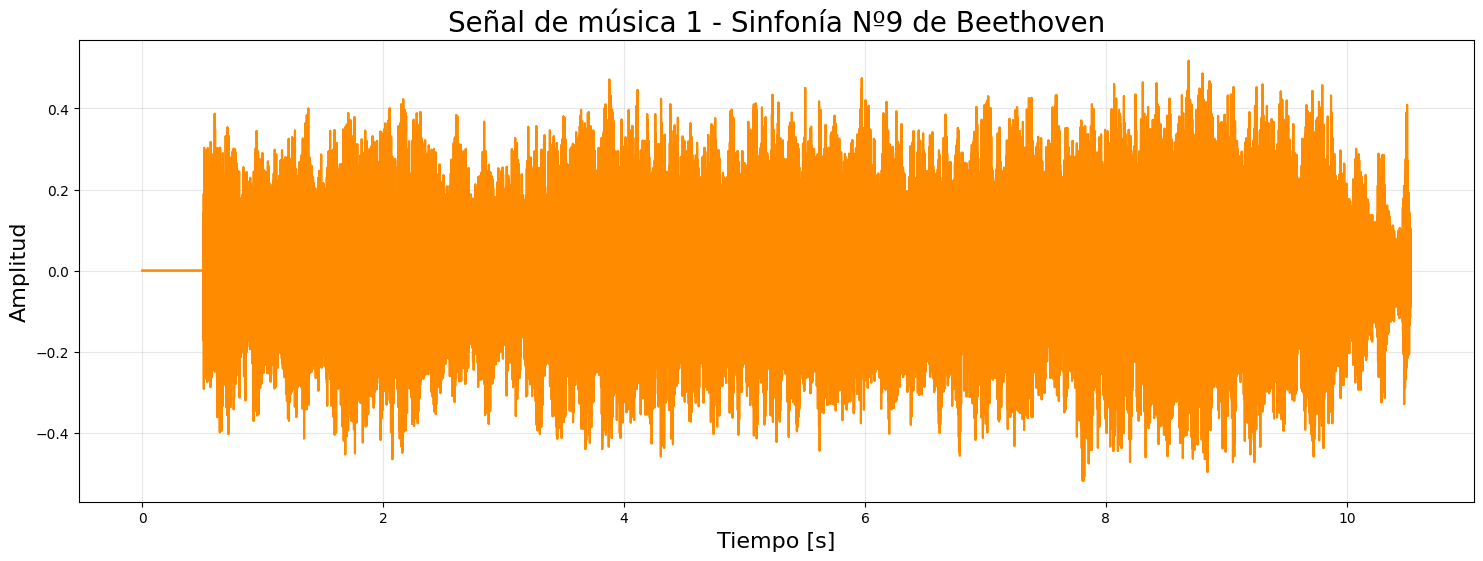

In [36]:
fs, x_b9s = read('../PASA-TP2/tracks/x_B9S.wav')
aux.plot_signal(x_b9s, fs, title="Señal de música 1 - Sinfonía Nº9 de Beethoven")

/var/folders/_t/g_d_mdfj26jg8hrgxw05jn6w0000gn/T/ipykernel_48789/3308006190.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x_waltz = read('../PASA-TP2/tracks/x_waltz.wav')


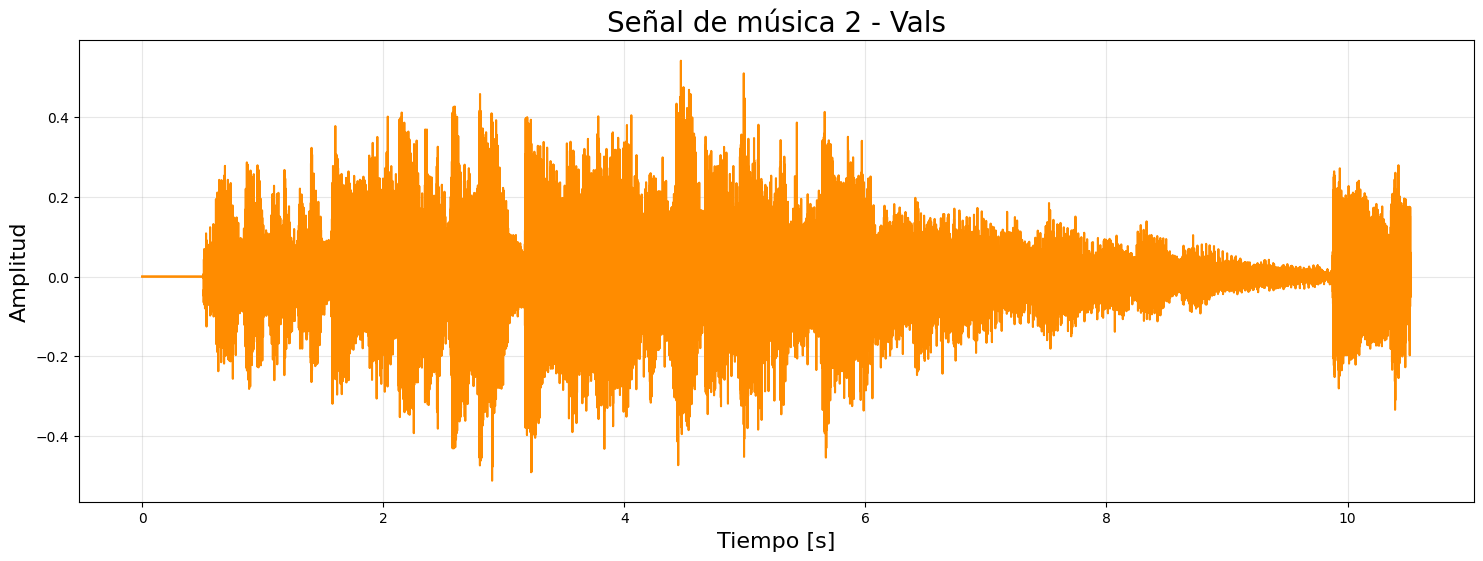

In [38]:
fs, x_waltz = read('../PASA-TP2/tracks/x_waltz.wav')
aux.plot_signal(x_waltz, fs, title="Señal de música 2 - Vals")

### 1.3 Señal rectangular $f=100Hz$ $x_3(n)$

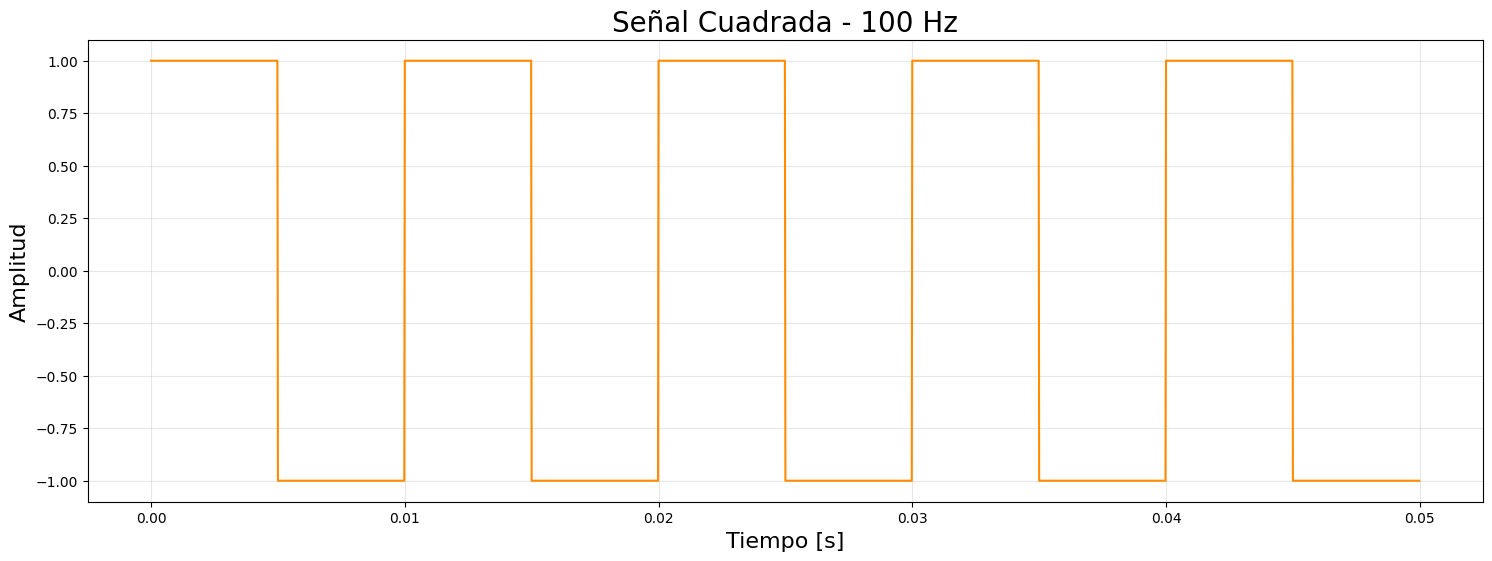

In [41]:
# Defino la frecuencia de la señal cuadrada
frequency = 100  # frecuencia en Hz
# Se utiliza una frecuencia de muestreo de 48KHz al ser la nativa de las placas de audio.
fs = 48e3
# Duración del tiempo de las grabaciones en segundos
time_frame = 10  

#Defino el tiempo de muestreo y la cantidad de muestras
num_samples = int(fs * time_frame)
t= np.linspace(0, time_frame, num_samples, endpoint=False)

# Genero la señal cuadrada usando la función signal.square de scipy
square_wave = signal.square(2 * np.pi * frequency * t)

#Ploteo la señal
aux.plot_signal(square_wave, fs, start=0, end=0.05,title="Señal Cuadrada - 100 Hz")

Analizo la respuesta es frecuencia de la señal generada para validar la sintesis de la señal deseada.

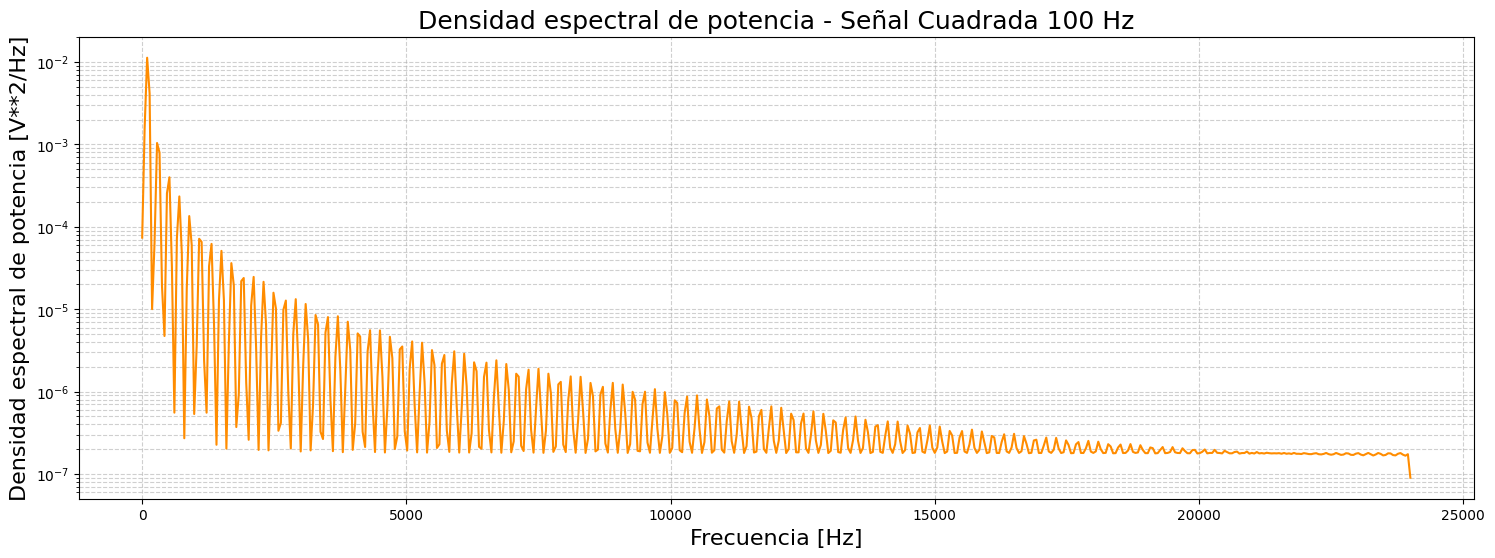

In [88]:
frec_s, psd = signal.welch(square_wave, fs, nperseg=1024)
aux.plot_psd_log(frec_s, psd, title="Densidad espectral de potencia - Señal Cuadrada 100 Hz")   

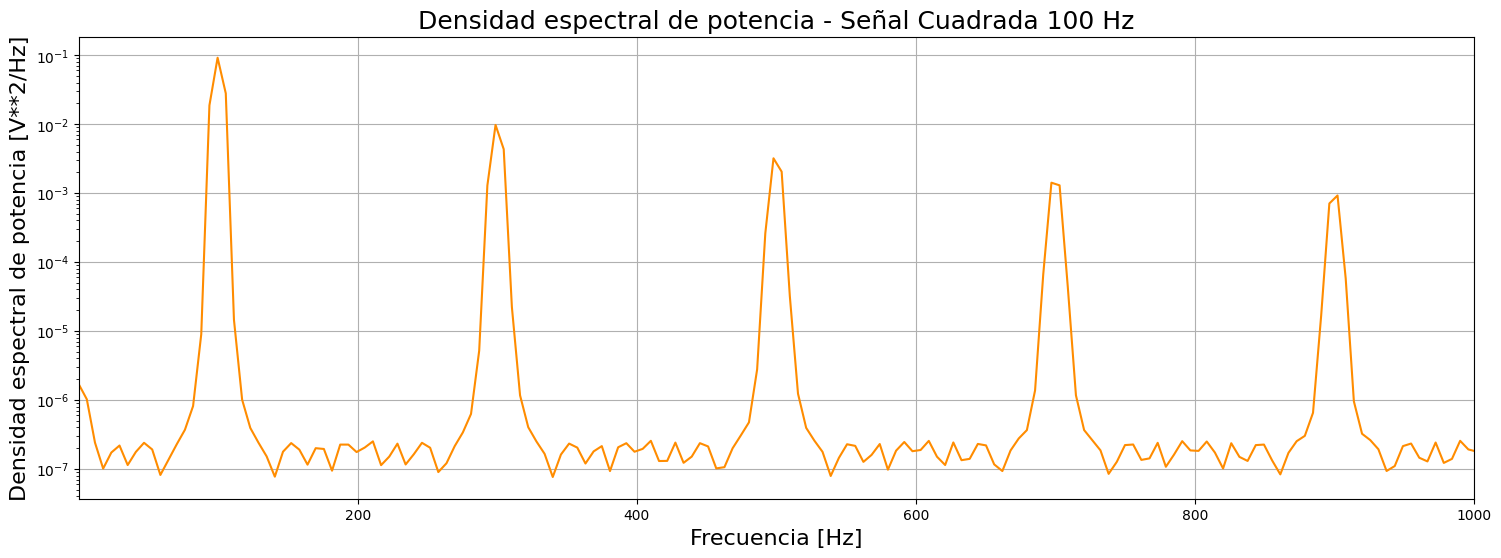

In [89]:
frec_s, psd = signal.welch(square_wave, fs, nperseg=8192)
plt.figure(figsize=(18, 6))
plt.semilogy(frec_s, psd, color="darkorange")
plt.title('Densidad espectral de potencia - Señal Cuadrada 100 Hz', fontsize=18)
plt.xlabel('Frecuencia [Hz]', fontsize=16)
plt.ylabel('Densidad espectral de potencia [V**2/Hz]', fontsize=16)
ylim = plt.xlim(0.1, 1e3)
plt.grid()
plt.show()

Se puede apreciar correctamente la frecuencia fundamental asi como también sus armónicos inpares. Se concluye que la señal se generó correctamente y se procede a guardarla.

Guardo la señal generada


In [57]:
# Guardar la señal cuadrada como archivo WAV
write('../PASA-TP2/tracks/x_square.wav', int(fs), square_wave.astype(np.float32))
print("Archivo guardado exitosamente en: ../tracks/x_square.wav")

Archivo guardado exitosamente en: ../tracks/x_square.wav


Escucho la señal generada

In [58]:
ipd.Audio(square_wave, rate=int(fs))

### 1.4 Señal de barrido lineal $x_4(n)$

Se genera un barrido lineal de frecuencia con $f_o$ = 20 Hz y $f_1$ =20 kHz.

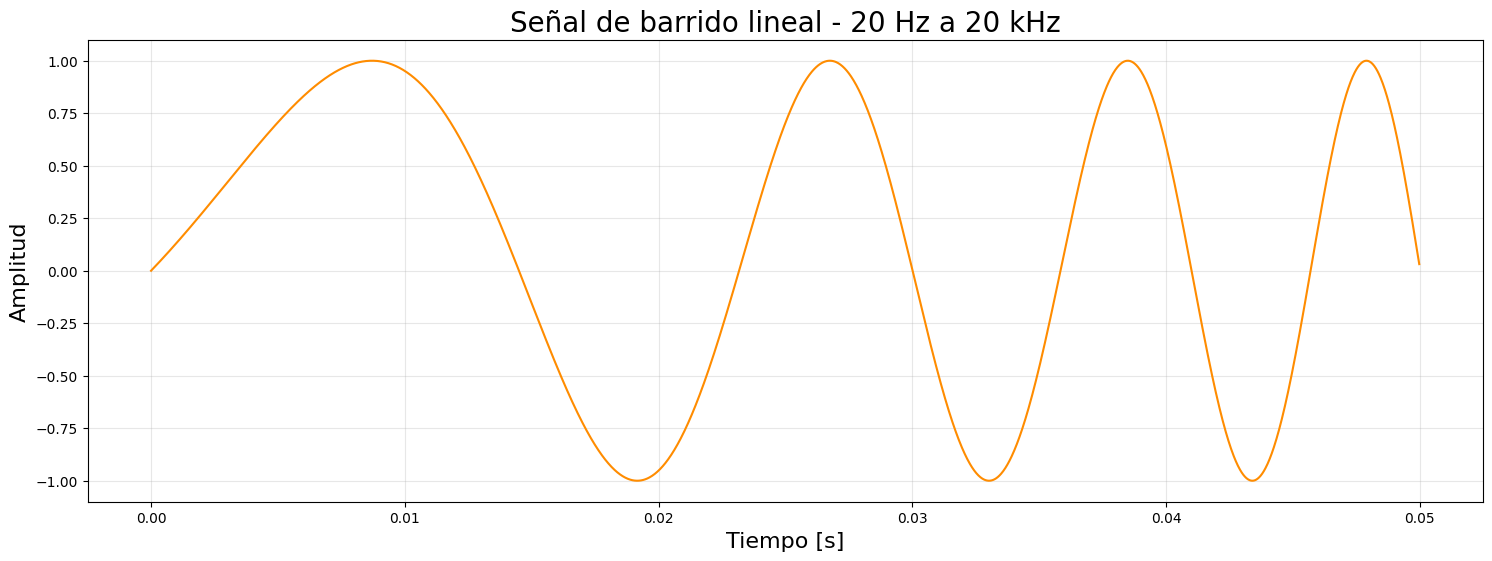

In [61]:
f1=20
f2=20e3
k=(f2-f1)/time_frame
t = np.linspace(0, time_frame, num_samples, endpoint=False)
linear_sweep = np.sin((2 * np.pi * f1 * t)+(2 * np.pi * k * (t*t)/2))
aux.plot_signal(linear_sweep, fs, start=0, end=0.05,title="Señal de barrido lineal - 20 Hz a 20 kHz")

Analizo la respuesta es frecuencia de la señal generada para validar la sintesis de la señal deseada.

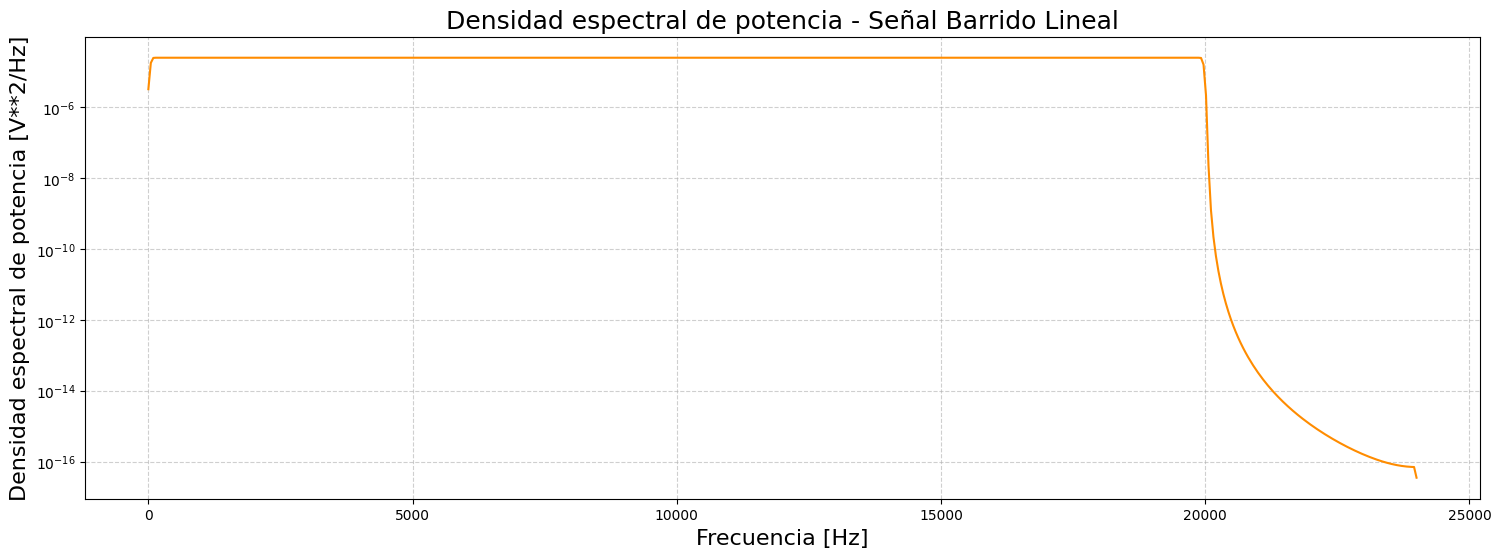

In [90]:
frec_s, psd = signal.welch(linear_sweep, fs, nperseg=1024)
aux.plot_psd_log(frec_s, psd, title="Densidad espectral de potencia - Señal Barrido Lineal")


Se puede apreciar el comportamiento esperado con contenido espectral de igual magnitud para todo el barrido.

Procedo a guardar la señal.

In [63]:
# Guardar la señal de barrido lineal como archivo WAV
write('../PASA-TP2/tracks/x_linsweep.wav', int(fs), linear_sweep.astype(np.float32))
print("Archivo guardado exitosamente en: ../tracks/x_linsweep.wav")

Archivo guardado exitosamente en: ../tracks/x_linsweep.wav


Reproduzco la señal generada.

In [64]:
ipd.Audio(linear_sweep, rate=int(fs))

### 1.4 Señal de barrido logarítmico $x_4(n)$

Se genera un barrido logarítmico de frecuencia con $f_o$ = 20 Hz y $f_1$ =20 kHz.

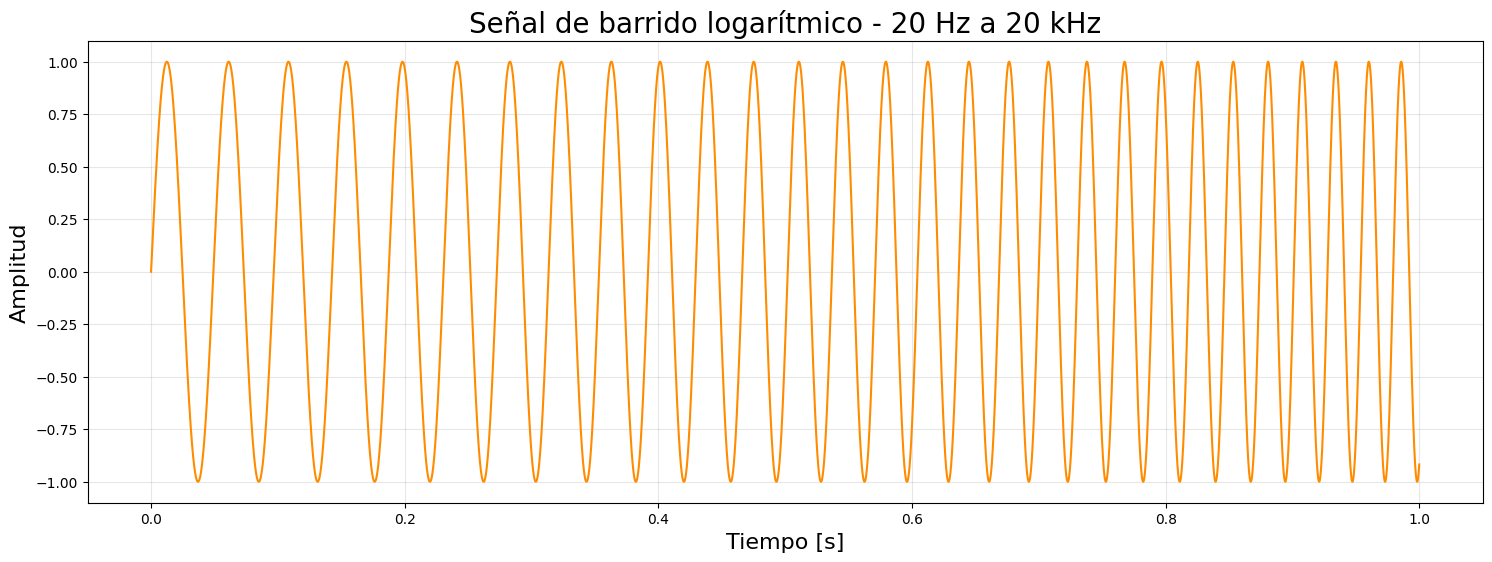

In [75]:
f1=20
f2=20e3
k= np.log(f2/f1)/time_frame
t = np.linspace(0, time_frame, num_samples, endpoint=False)
log_sweep = np.sin((2 * np.pi * f1 * (np.exp(k * t)-1))/k)
aux.plot_signal(log_sweep, fs, start=0, end=1,title="Señal de barrido logarítmico - 20 Hz a 20 kHz")

Ahora analizamos la PSD de la señal sintetizada.

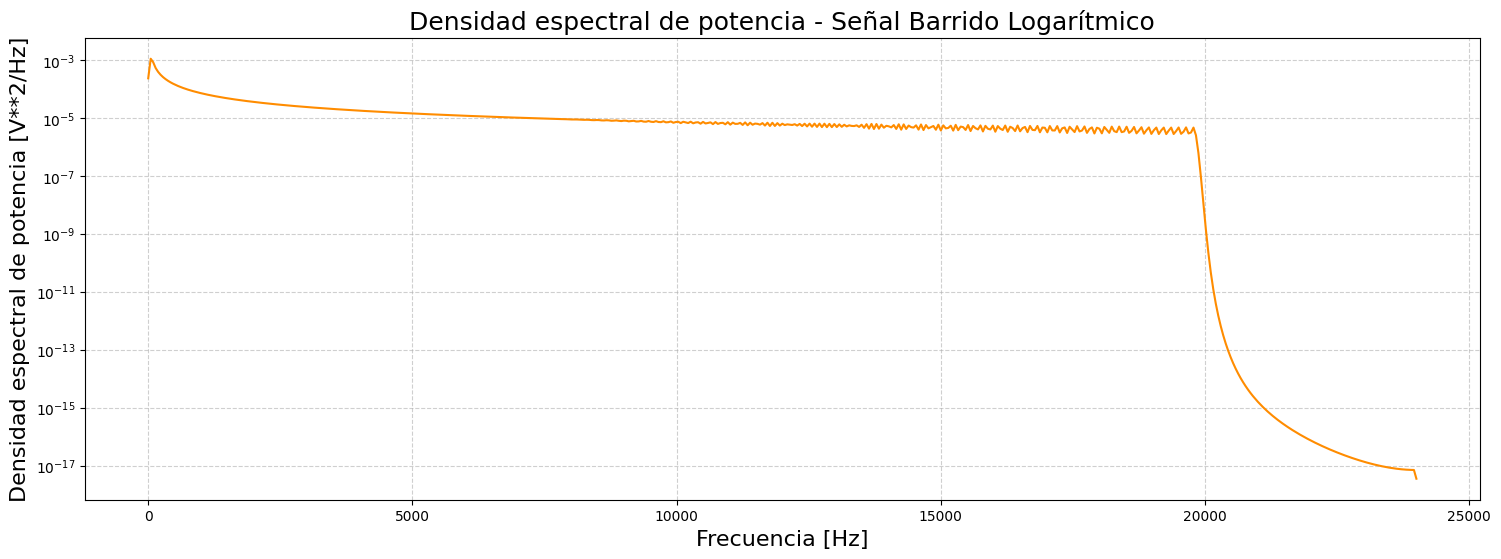

In [91]:
frec_s, psd = signal.welch(log_sweep, fs, nperseg=1024)
aux.plot_psd_log(frec_s, psd, title="Densidad espectral de potencia - Señal Barrido Logarítmico")

Tiene el espectro esperado con una mayor concentración a menores frecuencias debido al recorrido logarítmico.

Se procede a guardar la señal.

In [76]:
#Guardar la señal de barrido logaritmico como archivo WAV
write('../PASA-TP2/tracks/x_expsweep.wav', int(fs), log_sweep.astype(np.float32))
print("Archivo guardado exitosamente en: ../PASA-TP2/tracks/x_expsweep.wav")

Archivo guardado exitosamente en: ../PASA-TP2/tracks/x_expsweep.wav


Escuchamos la señal sintetizada.

In [72]:
ipd.Audio(log_sweep, rate=int(fs))

### 1.5 Ruido gausseano de media cero $x_5(n)$

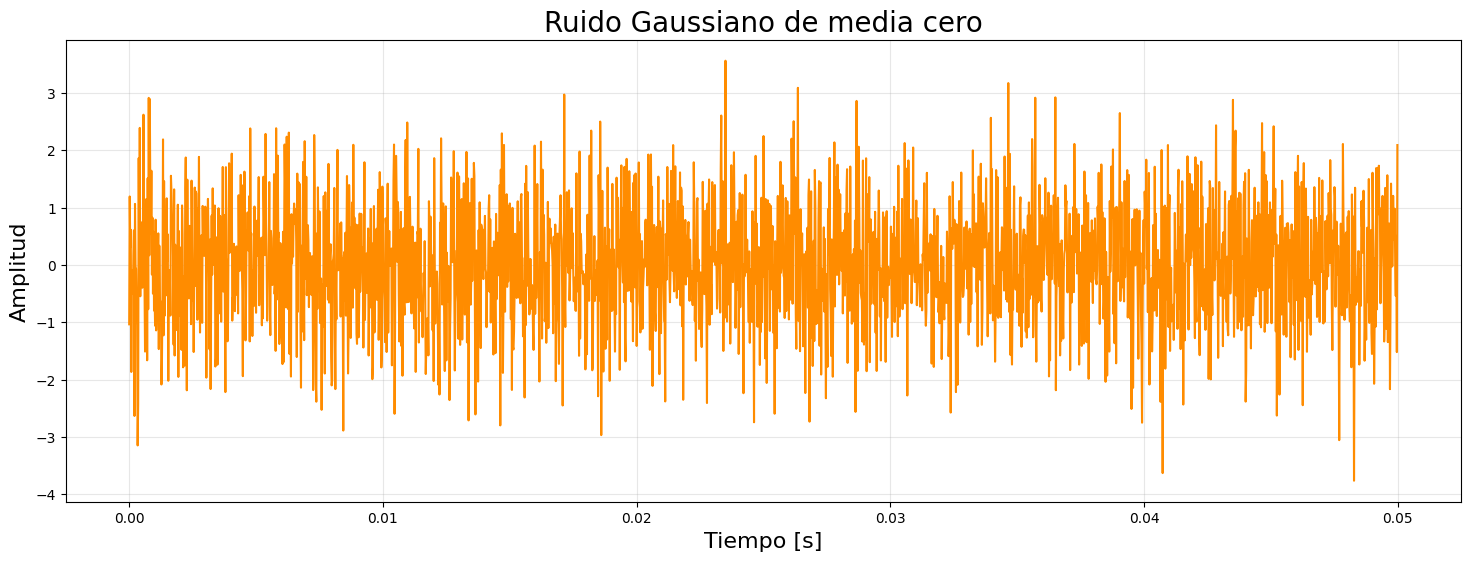

In [83]:
#Definimos los parámetros del ruido
mu = 0       # Media
sigma = 1  # Desviación estándar

# Muestramos el ruido blanco
x_awgn = np.random.normal(mu, sigma, num_samples)
aux.plot_signal(x_awgn, fs, start=0, end=0.05,title="Ruido Gaussiano de media cero")

Analizo el espectro del ruido blanco generado.

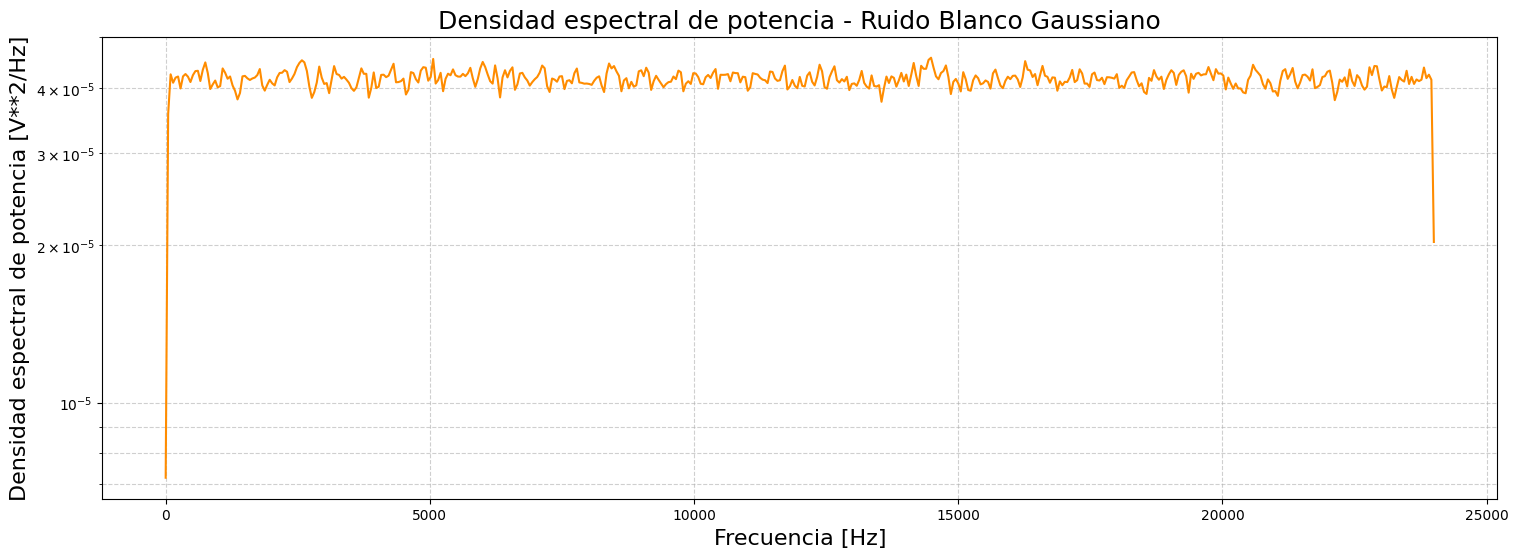

In [87]:
f,psd = signal.welch(x_awgn, fs, nperseg=1024)
aux.plot_psd_log(f, psd, title="Densidad espectral de potencia - Ruido Blanco Gaussiano")

El resultado es consistente, obteniendo un espectro plano. Procedemos a guardar la señal sintetizada.

In [85]:
write('../PASA-TP2/tracks/x_awgn.wav', int(fs), x_awgn.astype(np.float32))
print("Archivo guardado exitosamente en: ../PASA-TP2/tracks/x_awgn.wav")

Archivo guardado exitosamente en: ../PASA-TP2/tracks/x_awgn.wav


Escuchamos la señal sintetizada.

In [86]:
ipd.Audio(x_awgn, rate=int(fs))